In [1]:

import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error


In [2]:
# Parameters
T = 150  # Time steps
D = 5  # Number of features
categorical_dims = [3, 3]  # Number of unique values for each categorical feature
embedding_dim = 5
num_epochs = 1000


In [3]:
# Set seed for reproducibility
torch.manual_seed(19)


# Generate time-dependent patient features
time = torch.arange(1, T+1).float() / 50  # Normalize time for smoother variations
X = torch.zeros(T, D)

# Time-dependent patterns for features
for d in range(D):
    # Linear trend + sine wave pattern to simulate periodic changes (e.g., seasonal effects)
    X[:, d] = 0.1 * d * time + .1 * torch.sin(2 * math.pi * time / max(10, d + 1)) + torch.randn(T) * 0.1

# Categorical Variables
gender = torch.randint(0, 3, (T, 1))  # Three categories for gender
country = torch.randint(0, 3, (T, 1))  # Three countries
cat_vars = torch.cat([gender, country], dim=1)

# Adjusting Y for categorical variables and time
base_bp_gender = torch.tensor([0.0, 5.0, 3.0]).float()
binary_event = (1/(1 + torch.exp( -(1*X[:,0] + .5* X[:,2] -1* X[:,3]) -   .6* base_bp_gender[gender].squeeze() )) > .9).int()
# binary_event = (abs(X[:, 2] + X[:, 3] + X[:, 0]) > 3.5).int()
weights_X = torch.randn(D) * .1
Y = torch.matmul(X, weights_X)* 5  + torch.randn(T)*.1 + .1 * base_bp_gender[gender].squeeze()


X = torch.cat([X, cat_vars.float()], dim=1)

# Split data into training and testing sets
split_ratio = 0.8
split_idx = int(T * split_ratio)


X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     17.21
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           2.65e-15
Time:                        00:08:14   Log-Likelihood:                 24.954
No. Observations:                 120   AIC:                            -33.91
Df Residuals:                     112   BIC:                            -11.61
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0954      0.049      1.963      0.0

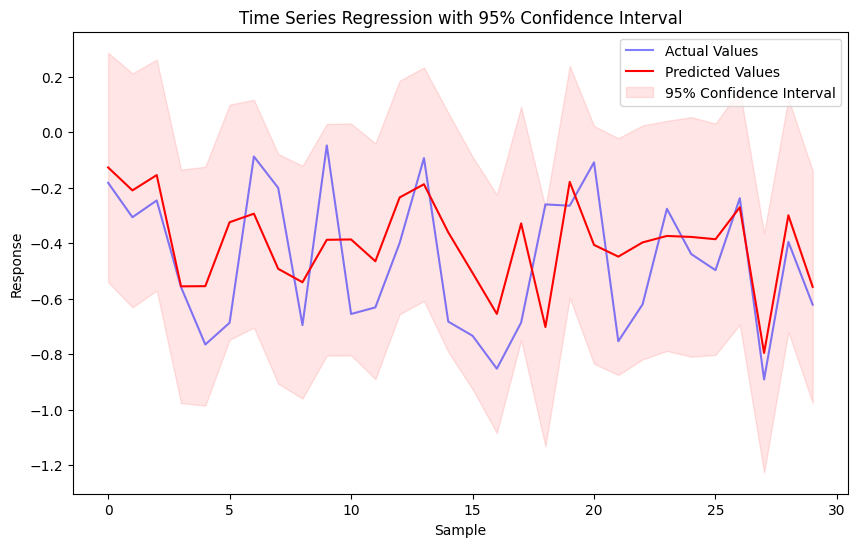

In [4]:

# Add a constant term for the intercept
X_train_const = sm.add_constant(X_train.numpy())
X_test_const = sm.add_constant(X_test.numpy())
Y_train = Y_train.numpy()

# Fit the model
model = sm.OLS(Y_train, X_train_const).fit()

# Predictions
predictions = model.predict(X_test_const)
print(model.summary())

# Visualization
plt.figure(figsize=(10, 6))

# Plotting test data points
plt.plot(range(len(Y_test)), Y_test, color='blue', label='Actual Values', alpha=0.5)

# Plotting predicted values
plt.plot(range(len(Y_test)), predictions, color='red', label='Predicted Values')

# Confidence interval
prediction_std, lower, upper = wls_prediction_std(model, exog=X_test_const, alpha=0.05)

# Plotting the confidence interval
plt.fill_between(range(len(Y_test)), lower, upper, color='r', alpha=0.1, label='95% Confidence Interval')

plt.xlabel('Sample')
plt.ylabel('Response')
plt.title('Time Series Regression with 95% Confidence Interval')
plt.legend()
plt.show()

In [5]:
mean_squared_error(Y_test, predictions)

0.04687738052269373

In [6]:
 model.llf

24.954076083902223